In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
from scipy.special import expit, logit
import scipy.stats
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.gof import powerdiscrepancy # modified locally, use 0.14 or see https://github.com/statsmodels/statsmodels/issues/8558


# The Model

The above analysis suggests that, irrespective of whether selection operates directly on handedness or on the alleles that underlie it,
in the face of cultural and evolutionary forces, human populations will reach an equilibrium state approximated by Eq. (3):

$$F_{DR}=\frac{2\alpha+2\beta-1+\sqrt{4\alpha^2-4\alpha+4\beta^2+1+8\beta\rho}}{4\beta}$$

$$F_{DL}=1-F_{DR}$$

When β=0 the corresponding equilibria are:

$$F_{DR}=\frac{1-2\alpha+2\rho}{2(1-2\alpha)}$$
$$F_{DL}=\frac{1-2\alpha-2\rho}{2(1-2\alpha)}$$

In [2]:

def compute_t(ρ, α, β):
    """Generate t - eq .3 - the true incidence of left-handedness

    From main text:
    F_DR is the final equilibrium frequency of right-handers with allele D fixed
    We need F_DL = 1 - F_DR
    """
    if np.isclose(β, 0): 
        FDR = (1 - 2 * α + 2 * ρ) / (2 * (1 - 2 * α))  # eq 3a
    else:
        Δ = 4 * α * α - 4 * α + 4 * β * β + 1 + 8 * β * ρ
        FDR = (2 * α + 2 * β - 1 + np.sqrt(Δ)) / (4 * β)  # eq 3
        assert 0 < 1 - FDR < 1, ("t is the problem! t = ", 1-FDR)
    return 1 - FDR


"Centra to out model is the assumption that selection has eliminated all genetic variation contributing to handedness. Variation in handedness can, nontheless, be account for by the fact that individuals homozygous for the D allel will
beexclusivly right handed if:
$$\alpha+\rho = \frac{1}{2}$$
as required by both leading genetic models of handedness.

**If, as we assume: $$\alpha+\rho < \frac{1}{2}$$ left handers will remain in the population at a frequancy given by P(DL) in eq(3)**


In [3]:
def validate(θ):
    if len(θ) == 3:
        ρ, α, β = θ
    elif len(θ) == 2:
        ρ, α = θ
        β = 0
    else:
        raise ValueError("Length of θ is {}".format(len(θ)))

    if (not 0 <= ρ <= 1) or (not 0 <= α <= 1) or (not 0 <= β <= 1) or (ρ + α >= 0.5) or (ρ - α > 0.5) or (ρ + β > 0.5): 
        return False
    return True

Estimated for  ρ, α and β can be obtained by conducting a maximum likelihood analysis of the data from prevoius studies of the frequancies of right- and left- handed children born to RXR, RXL, and LXL parental mating. 
The analysis is detailed at appendix 3.

___
 *Appendix 3: maximum likelihood analysis*

 


Provided that estimates of p, α, and β are available, the P_ij,kxl from Table I can be used to predict expected frequencies of left- and righthanders for a given mating, which can then be compared to the observed data.

*T* is the predicted true probability of child | parents: 

$$ T = p(H_t|H_t x H_t)


In [4]:
def compute_T(ρ, α, β):
    """Generate T - column DD in Table 1

    From Appendix 3:
    T is a 3 x 2 matrix of p(Ht | Ht x Ht) entries -
    probability of a truly H child from a mating where parents are truly H
    """
    return np.array([
        # R           L
        [0.5 + ρ + α, 1 - (0.5 + ρ + α)],  # RxR
        [0.5 + ρ + β, 1 - (0.5 + ρ + β)],  # RxL
        [0.5 + ρ - α, 1 - (0.5 + ρ - α)]  # LxL
    ])


 The matrix M gives the predicted probabilities of a child classified as right- or left-handed being born to matings classified as RxR, RxL, and LxL. If the number of children observed to be rightand left-handed that are born to parents both classified as fight-handed are denoted as N_(R|RXR) and N_(L|RXR) with the same notation for other observed matings, then the likelihood (L) of a set of probabilities (Mi) given an observed data set (Di) can be defined as being proportional to the product of the binomial probabilities for the three mating classes.

 The log likelihood function is given by:
 $$S(M_i|D_i) = N_{R|RXR} In[p(R_m|R_mxR_m)] + N_{L|RXR} In[p(L_m|R_mxR_m)] + N_{R|RXL} In[p(R_m|R_mxL_m)] + \\ N_{L|RXL} In[p(L_m|R_mxL_m)]+ N_{R|LXL} In[p(R_m|L_mxL_m)] + N_{L|LXL} In[p(L_m|L_mxL_m)]$$


In [5]:
def log_likelihood(θ, Data):
    
    # D = np.atleast_2d(Data) 
    if len(θ) == 3:
        ρ, α, β = θ
    elif len(θ) == 2:
        ρ, α = θ
        β = 0
    else:
        raise ValueError("Length of θ is {}".format(len(θ)))

    if not validate(θ):
        return -np.inf


    S = 0

    T = compute_T(ρ, α, β)
    t = compute_t(ρ, α, β)
    assert ((0 <= T) & (T <= 1)).all(), "T is the problem"
    assert 0 <= t <= 1, "t is the problem"


    for D in Data:
        # mp, mo = compute_mp_mo(D_)
        # assert 0 < mp < 1
        # assert 0 < mo < 1

        # P = compute_P(mp, t)
        # assert ((0 <= P) & (P <= 1)).all()
        
        # O = compute_O(mo, t)
        # assert ((0 <= O) & (O <= 1)).all()
        
        # M = compute_M(T, P, O)
        # assert ((0 <= M) & (M <= 1)).all()

        logT = np.log(T) #changed to logT (M->T)

        S += (
                D[0] * logT[0, 0] +  # R|RxR
                D[1] * logT[0, 1] +  # L|RxR
                D[2] * logT[1, 0] +  # R|RxL
                D[3] * logT[1, 1] +  # L|RxL
                D[4] * logT[2, 0] +  # R|LxL
                D[5] * logT[2, 1]  # L|LxL
        )

    return S

Curreting the prediction assuming sampling bias due to critira shift.

Assuming:
- t is the *true* incidance of left handedness in the population, therefore is fixed across studies and generations
- mp is the *manifested* incidance of left handedness in the parents generation
- mo is the *manifested* incidance of left handedness in the offspring generation

- if the true incidance (t) > it is entierly due to true left handed (Lt) manifasting as right handed (Rm)
- if the true incidance (t) < it it is entierly due to true right handers (Rt) manifesting as left handers (Lm)


In [6]:
def compute_mp_mo(D):
    assert D.ndim == 1, ("D.ndim = ",D.ndim) 
    # D 0 R|RxR 1 L|RxR 2 R|RxL 3 L|RxL 4 R|LxL 5 L|LxL
    mp = (D[2] + D[3] + 2 * D[4] + 2 * D[5]) / (2 * D.sum())
    mo = (D[1] + D[3] + D[5]) / D.sum()
    return mp, mo

Transition matrices for correcting offspring and parents sampling errors:

The challange if to transform T into *M* - the probability that a child *measured* as H is produced from parents measured as H

$$ M= p(H_m | H_m x H_m)$$

To this end, currection should be made for the parents and offspring generations sepreatly. 

1. Parents: the matrix P gives the probability that a couple measured as H are truly H.
2. Offspring: the matrix O  gives the probability that a child measured as H is truly H.

Following the corrections:

$$ M=PTO$$




**The matrix P**

P is a 3 • 3 matrix whose entries give the probability that a mating measured as R • R, R • L, or L • L is truly a R • R, R • L, or L • L mating.

$$ P= p(H_t x H_t | H_m x H_m)$$

Hence:

<!-- $$P =\begin{pmatrix} p(R_txR_t|R_mxR_m) & p(R_txR_t|R_mxL_m) & p(R_txR_t|L_mxL_m) \\  & p(R_txL_t|R_mxL_m) & p(R_txL_t|L_mxL_m) \\  & p(L_txL_t|R_mxL_m) & p(L_txL_t|L_mxL_m) \end{pmatrix}$$

$$P =\begin{pmatrix} p(R_txR_t|R_mxR_m) & p(R_txL_t|R_mxR_m) & p(L_txL_t|R_mxR_m) \\ p(R_txL_t|R_mxR_m) & p(R_txL_t|R_mxL_m) & p(R_txL_t|L_mxL_m) \\ p(L_txL_t|R_mxR_m) & p(L_txL_t|R_mxL_m) & p(L_txL_t|L_mxL_m) \end{pmatrix}$$ -->

If $$ m_p > t:$$


In [7]:

def compute_P(mp, t):

    if mp > t:

        u = (mp - t) / mp
        assert 0 <= u < 1, "u is the problem"
        
        P = np.array([
            [1, 0, 0],
            [u, 1 - u, 0],
            [u * u, 2 * u * (1 - u), (1 - u) * (1 - u)]
        ])

    if mp < t: #changed from "else"

        v = (t - mp) / (1 - mp)  # fixed from: (t - mp)/t
        assert 0 <= v <= 1, "v is the problem"

        P = np.array([
            [(1 - v) * (1 - v), 2 * v * (1 - v), v * v],
            [0, 1 - v, v],
            [0, 0, 1]
        ])
        
    return P

O is transition matrix for oggspring generation....

In [8]:

def compute_O(mo, t):

    if mo > t:

        w = (mo - t) / (1 - t)
        assert 0 <= w < 1, "w is the problem"

        O = np.array([
            [1 - w, w],
            [0, 1]
        ])
        
    if mo < t: #changed from "else"

        x = 1 - mo / t
        assert 0 <= x <= 1, "x is the problem"
        
        O = np.array([
            [1, 0],
            [x, 1 - x]
        ])

    return O

In [9]:
def compute_M(T, P, O):
    M = P @ T @ O
    assert ((0 <= M) & (M <= 1)).all(), "M is the problem"
    return M

# Data

In [10]:
#    R|RxR  L|RxR  R|RxL  L|RxL  R|LxL  L|LxL

D = [
    [841,  115,   113,   54,    1,    7],   # Ramaley 1913, paper says it does not fit
    [6917, 308,   411,   53,    18,    7],  # Chamberlain 1928
    [1842, 151,   140,   34,    5,     6],  # Rife 1940
    [140,  34,    33,    20,    8,     2],  # Merrell 1975
    [6206, 669,   471,   125,   5,     1],  # Annett 1973
    [154,  11,    31,    9,     0,     0],  # Ferronato et al. 1947
    [232,  17,    41,    7,     3,     1],  # Mascie-Taylor (unpub, in McManus 1985)
    [1060, 144,   122,   46,    3,     4],  # Chaurasia & Groswani (unpub, in McManus 1985)
    [1656, 130,   170,   40,    4,     0],  # Annett 1978
    [303,  37,    45,    15,    0,     0],  # Carter-Saltzmann 1980
    [315,  68,    57,    16,    0,     0],  # Coren & Porac 1980
    [848,  211,   325,   150,   30,   22],  # McGee & Cozad 1980
    [58,   9,     14,    5,     0,     0],  # McManus 1985 ICM1
    [134,  15,    17,    9,     1,     0],  # McManus 1985 ICM2prop
    [74,   4,     6,     2,     0,     0],  # McManus 1985 ICM2mat
    [86,   4,     8,     1,     0,     0],  # McManus 1985 ICM2pat
    [1729, 173,   281,   63,    8,     3]   # Leiber & Axelrod 1981
]
D = np.array(D)


# Maximum Likelihood Estimation

## MLE using Nelder-Mead 

In [11]:
def neg_log_likelihood(θ, Data):
    return -log_likelihood(θ, Data)

In [12]:
def fit(n_parameters,data):
    θ_hat = None
    logL = -np.inf
    for _ in range(1000):
        θ0 = np.random.random(n_parameters)/(n_parameters)
        result = opt.minimize(neg_log_likelihood, θ0, args=(data,), method='Nelder-Mead')
        if -result.fun > logL:
            logL = -result.fun
            θ_hat = result.x
            print(θ_hat, logL, flush=True)
    return θ_hat, logL

### Three parametes: ρ, α, β

In [13]:
θ_mle_3par, logL_3par = fit(3, D)

[0.26684412 0.14811584 0.01196707] -8826.64285384999


/Users/ronykarstadt/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/optimize.py:761: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


[0.26681115 0.14815122 0.0119895 ] -8826.64285222317
[0.26682473 0.14813681 0.0119763 ] -8826.642851868344


In [14]:
print("MLE estimate (3 parameters)",'\n',"-"*20,'\n')
print("logL= {:.2f}".format(log_likelihood(θ_mle_3par, D)))
print("ρ={:.3f}, α={:.3f}, β={:.3f}".format(*θ_mle_3par),'\n')

print("α+ρ<0.5:",θ_mle_3par[:2].sum()<0.5,'\n')

print("F_DL= {:.2f}%".format(compute_t(*θ_mle_3par)*100))

MLE estimate (3 parameters) 
 -------------------- 

logL= -8826.64
ρ=0.267, α=0.148, β=0.012 

α+ρ<0.5: True 

F_DL= 11.73%


### TWO parametes: ρ, α

In [15]:
θ_mle_2par, logL_2par = fit(2, D)

[0.27735024 0.137646  ] -8826.79277767282
[0.27728995 0.13770403] -8826.792772845893
[0.2773411 0.1376677] -8826.792772210832
[0.27731837 0.13768797] -8826.792760458948
[0.27729767 0.13770644] -8826.792760007873
[0.27729648 0.13770621] -8826.792759810503
[0.27731796 0.13768717] -8826.792759081787
[0.27732422 0.13767873] -8826.792758961961
[0.27730821 0.13769503] -8826.792757744895


In [16]:
print("MLE estimate (3 parameters)",'\n',"-"*20,'\n')
print("logL= {:.2f}".format(log_likelihood(θ_mle_2par, D)))
print("ρ={:.3f}, α={:.3f}".format(*θ_mle_2par),'\n')

print("α+ρ<0.5:",θ_mle_2par[:2].sum()<0.5,'\n')

print("F_DL= {:.2f}%".format(compute_t(*θ_mle_2par,β=0)*100))

MLE estimate (3 parameters) 
 -------------------- 

logL= -8826.79
ρ=0.277, α=0.138 

α+ρ<0.5: True 

F_DL= 11.73%


In [17]:
t=compute_t(*θ_mle_2par,β=0)
T=compute_T(*θ_mle_2par,β=0)

## Grid search 

### Three parametes: ρ, α, β

In [22]:
pts = 200
ρs = np.linspace(0, 1, pts)
αs = np.linspace(0, 1, pts)
βs = np.linspace(0, 1, pts)
# θs = np.array([ρs, αs, βs]) 
grid = np.meshgrid(ρs, αs, βs) # !!!! this is the problem -> flips between ρs and αs. Variable grid was removed and ρs, αs, βs were used individualy.  

grid_logL = np.zeros((pts, pts, pts))
# futs = grid_logL.tolist() # deleted

# with ThreadPoolExecutor() as pool: 
for i, ρ_ in enumerate(ρs):
    print(i, end=' ', flush=True)
    for j, α_ in enumerate(αs):
        for k, β_ in enumerate(βs):
            θ_ = ρ_, α_, β_
            grid_logL[i,j,k] = log_likelihood(θ_, D) # changed from-> futs[i][j][k] = pool.submit(log_likelihood, θ_, D)

for i, ρ_ in enumerate(ρs):
    for j, α_ in enumerate(αs):
        for k, β_ in enumerate(βs):
             # if futs[i][j][k].exception():
            #         print("Problem with", ρ_, α_, β_, ":", futs[i][j][k].exception())
            #         grid_logL[i,j,k] =  -np.inf
            # else: grid_logL[i,j,k] = futs[i][j][k].result() #chank changed to -> 
            try: 
                grid_logL[i,j,k] = grid_logL[i,j,k] 
            except Exception as e:
                    print("Problem with", ρ_, α_, β_, ":", e)
                    grid_logL[i,j,k] = -np.inf

imax = np.unravel_index(np.argmax(grid_logL), grid_logL.shape) # changed from -> imax = grid_logL.ravel().argmax()
θ_grid=(ρs[imax[0]], αs[imax[1]], βs[imax[2]]) #changed from-> θ_grid = (grid[0].ravel()[imax], grid[1].ravel()[imax], grid[2].ravel()[imax])


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

In [23]:
print("Grid 3D MLE estimate: \nlogL={:.5f}".format(log_likelihood(θ_grid, D)))
print("ρ={:.3f}, α={:.3f}, β={:.3f}".format(*θ_grid))

Grid 3D MLE estimate: 
logL=-8827.42146
ρ=0.266, α=0.151, β=0.010


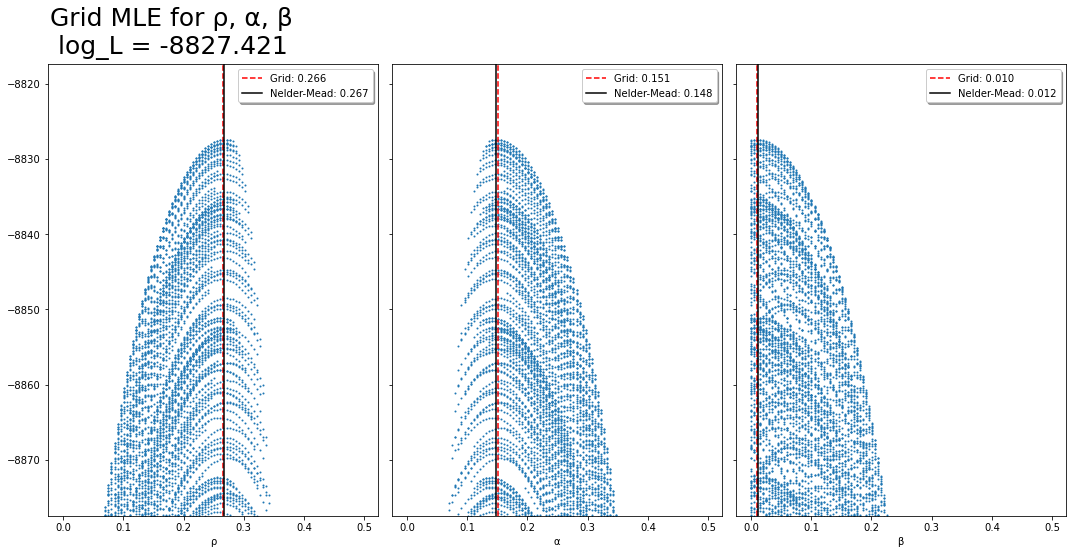

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(15, 7), sharey=True)
labels = 'ρ α β'.split()

#rho
ax = axes[0]
ax.plot()
ax.plot(grid[1].ravel(), grid_logL.ravel(), '.', markersize=2) #grid[0] -> canged to grid[1]
ax.axvline(θ_grid[0], ls='--', color='r', label="Grid: {:.3f}".format(θ_grid[0])) 
ax.axvline(θ_mle_3par[0], color='k', label="Nelder-Mead: {:.3f}".format(θ_mle_3par[0]))
ax.set_xlabel(labels[0])
ax.set_ylim(grid_logL.max()-50, grid_logL.max()+10)
legend = ax.legend(loc='upper right', shadow=True)

#alpha
ax = axes[1]
ax.plot()
ax.plot(grid[0].ravel(), grid_logL.ravel(), '.', markersize=2) #grid[1]-> changed to grid[0]
ax.axvline(θ_grid[1], ls='--', color='r', label="Grid: {:.3f}".format(θ_grid[1]))
ax.axvline(θ_mle_3par[1], color='k', label="Nelder-Mead: {:.3f}".format(θ_mle_3par[1]))
ax.set_xlabel(labels[1])
ax.set_ylim(grid_logL.max()-50, grid_logL.max()+10)
legend = ax.legend(loc='upper right', shadow=True)

#beta
ax = axes[2]
ax.plot()
ax.plot(grid[2].ravel(), grid_logL.ravel(), '.', markersize=2) #grid[1]-> changed to grid[0]
ax.axvline(θ_grid[2], ls='--', color='r', label="Grid: {:.3f}".format(θ_grid[2]))
ax.axvline(θ_mle_3par[2], color='k', label="Nelder-Mead: {:.3f}".format(θ_mle_3par[2]))
ax.set_xlabel(labels[2])
ax.set_ylim(grid_logL.max()-50, grid_logL.max()+10)
legend = ax.legend(loc='upper right', shadow=True)


fig.text(0.05, 1, s='Grid MLE for ρ, α, β \n log_L = {:.3f}'.format(log_likelihood(θ_grid, D)), fontsize =25)
fig= fig.tight_layout()

In [25]:

#____________________________________________run this see results before change:________________________________________

imax_before = grid_logL.ravel().argmax()
θ_grid_before = (grid[0].ravel()[imax_before], grid[1].ravel()[imax_before], grid[2].ravel()[imax_before])


print("Grid 3D MLE estimate, logL={:.5f}".format(log_likelihood(θ_grid_before, D)))
print("ρ={:.3f}, α={:.3f}, β={:.3f}".format(*θ_grid_before))

Grid 3D MLE estimate, logL=-8940.87306
ρ=0.151, α=0.266, β=0.010


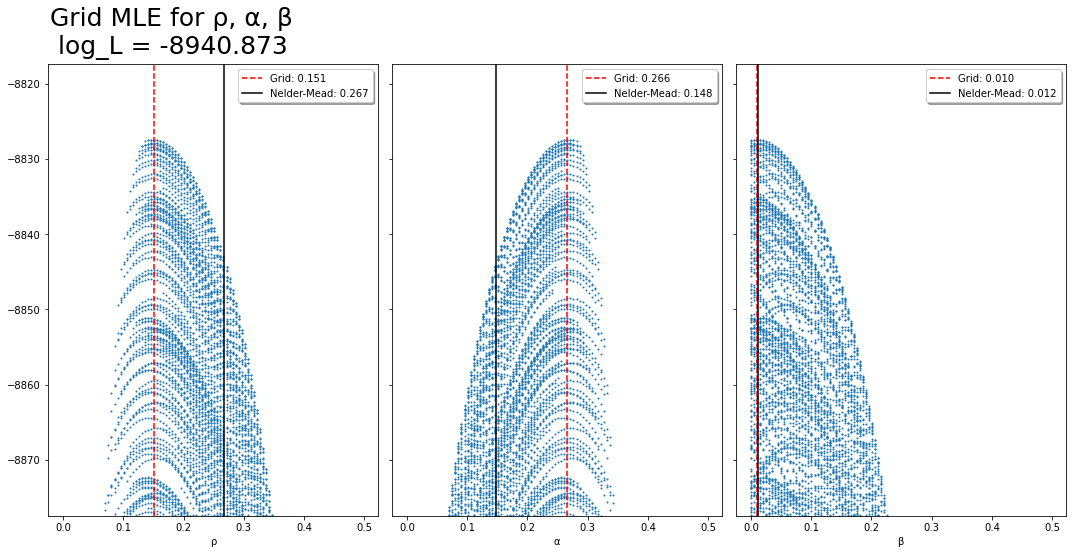

In [26]:
#____________________________________________plot results before change:________________________________________

fig, axes = plt.subplots(1, 3, figsize=(15, 7), sharey=True)
labels = 'ρ α β'.split()
for i in range(0,len(θ_grid_before)):
    ax = axes[i]
    ax.plot(grid[i].ravel(), grid_logL.ravel(), '.', markersize=2)
    ax.axvline(θ_grid_before[i], ls='--', color='r', label="Grid: {:.3f}".format(θ_grid_before[i]))
    # ax.axhline(log_likelihood(θ_grid, D))
    ax.axvline(θ_mle_3par[i], color='k', label="Nelder-Mead: {:.3f}".format(θ_mle_3par[i]))
    ax.set_xlabel(labels[i])
    ax.set_ylim(grid_logL.max()-50, grid_logL.max()+10)
    legend = ax.legend(loc='upper right', shadow=True)

fig.text(0.05, 1, s='Grid MLE for ρ, α, β \n log_L = {:.3f}'.format(log_likelihood(θ_grid_before, D)), fontsize =25)


fig= fig.tight_layout()

## G-test

In [27]:
# Generate expected table for the data using the manipulations in appendix 3:

Exp_table = np.array([]) 

for D_ in D:
    mp, mo = compute_mp_mo(D_)
    assert 0 < mp < 1, "mp is not right"
    assert 0 < mo < 1, "mo is not right"

    P = compute_P(mp, t)
    assert ((0 <= P) & (P <= 1)).all()
        
    O = compute_O(mo, t)
    assert ((0 <= O) & (O <= 1)).all()
        
    M = compute_M(T, P, O)
    assert ((0 <= M) & (M <= 1)).all()

    Obs= D_.copy()
    Exp= M.reshape(6).copy()

    Exp[:2] *= Obs[:2].sum()
    Exp[2:4] *= Obs[2:4].sum()
    Exp[4:] *= Obs[4:].sum()
    Exp[Exp==0] = 1e-16


    Exp_table = np.append(Exp_table, Exp)

Exp_table = Exp_table.reshape(17,6)

$$ G = 2\sum_iO_i\cdot ln(\frac{O_i}{E_i})$$
#G gets bigger as the observed data get further from the null expectation

Where:
$$\sum_i O_i = \sum_i E_i = N $$
$$O_i\ge 0$$
$$E_i >0 $$ 

**put all the assumption of the test here proporly including p value and critical value and null hypothesis**

$$ H_0 : O_i = E_i$$
$$ H_1 : O_i \ne E_i$$

In [28]:
def G_test(Observed, Expected, df):

    Observed_sum= Observed.sum()
    Expected_sum= round(Expected.sum(),0)
    assert (Observed_sum == Expected_sum), ("observed and expected sums are not equal")

    Gsum = 0

    for i in range(0,len(Observed)):
        if (Observed[i]>0) & (Expected[i]>0):
            log = np.log(Observed[i]/Expected[i])
            Gsum+= Observed[i]*log

    Gsum = round(2*Gsum,2) 
    p_value = round(scipy.stats.chi2.sf(Gsum, df),2)

    if p_value<0.05:
        Gsum ='{}*'.format(Gsum)


    print("G=",Gsum,"pvalue=",p_value)
    
    return Gsum, p_value

In [29]:
#G-test for entire table:
Ex= Exp_table.reshape(102)
Ob= D.reshape(102)
G_total, pvalue_total =G_test(Ob,Ex,df=32)

G= 43.87 pvalue= 0.08


In [30]:
#G_test for each study
G_all =np.array([])

for i in range(0,len(D)):
    G_idx, pvalue_idx =G_test(D[i], Exp_table[i],df=1.88)

    G_all=np.append(G_all,G_idx)

    

G= 13.21* pvalue= 0.0
G= 5.22 pvalue= 0.07
G= 4.56 pvalue= 0.09
G= 3.33 pvalue= 0.17
G= 0.81 pvalue= 0.64
G= 0.55 pvalue= 0.73
G= 0.11 pvalue= 0.93
G= 1.76 pvalue= 0.39
G= 3.27 pvalue= 0.18
G= 0.04 pvalue= 0.97
G= 2.17 pvalue= 0.31
G= 3.6 pvalue= 0.15
G= 0.0 pvalue= 1.0
G= 2.61 pvalue= 0.25
G= 0.88 pvalue= 0.61
G= 0.01 pvalue= 0.99
G= 1.73 pvalue= 0.39


## Summary

In [31]:
forplot = np.array([])

for i in range(0,len(Ob)):
    E_idx = round(Ex[i],1)
    E_idx = '({})'.format(E_idx)

    O_idx= str(Ob[i])

    O_E = O_idx+' '+E_idx
    
    forplot = np.append(forplot,O_E)


In [32]:
plot_laland= pd.DataFrame(data = forplot.reshape(17,6),
                          index=['Ramaley 1913','Chamberlain 1928','Rife 1940','Merrell 1975', 'Annett 1973', 'Ferronato et al. 1947', 
                                 'Mascie-Taylor (unpub, in McManus 1985)', 'Chaurasia & Groswani', 'Annett 1978', 'Carter-Saltzmann 1980', 'Coren & Porac 1980',
                                  'McGee & Cozad 1980', 'McManus 1985 ICM1', 'McManus 1985 ICM2prop', 'McManus 1985 ICM2mat', 'McManus 1985 ICM2pat',
                                'Leiber & Axelrod 1981'],
                            columns= pd.MultiIndex.from_product([['RxR','RxL','LxL',], ['R', 'L']])
                            )
                          
                          
                          
plot_laland["G (df=1.88)"]= G_all


In [36]:
plot_laland.style.set_caption("Replication of Laland et al 1995")